In [1]:
import setup
setup.init_django()
from market import services as market_services
from market import tasks as market_tasks
from market.models import Company
import json
from decouple import config

In [2]:
ticker = "AAPL"
name = "Apple"
company, _ = Company.objects.get_or_create(name=name, ticker=ticker)
company.id

2

In [3]:
market_tasks.sync_historical_stock_data(
    years_ago=1, 
    company_ids=[company.id], 
    use_celery=False, 
    verbose=True
)

# use celery / async
# market_tasks.sync_historical_stock_data.delay(years_ago=5, company_ids=[company.id], use_celery=True, verbose=False)

Historical sync days ago 30
dataset length 3398
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
30 done

Historical sync days ago 60
dataset length 6730
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
60 done

Historical sync days ago 90
dataset length 10788
Doing chunk 0
finished chunk 0
Doing chunk 1000
finished chunk 1000
Doing chunk 2000
finished chunk 2000
Doing chunk 3000
finished chunk 3000
Doing chunk 4000
finished chunk 4000
Doing chunk 5000
finished chunk 5000
Doing chunk 6000
finished chunk 6000
Doing chunk 7000
finished chunk 7000
Doing chunk 8000
finished chunk 8000
Doing chunk 9000
finished chunk 9000
Doing chunk 10000
finished chunk 10000
90 done

Historical sync days ago 120
d

HTTPError: 429 Client Error: Too Many Requests for url: https://api.polygon.io/v2/aggs/ticker/AAPL/range/5/minute/2024-07-19/2025-01-16?adjusted=True&sort=asc&limit=50000

In [4]:
days = 90
queryset = market_services.get_daily_stock_quotes_queryset(ticker, days=days)

In [5]:
averages = market_services.get_daily_moving_averages(ticker, days=days, queryset=queryset)
price_target = market_services.get_price_target(ticker, days=days, queryset=queryset)
volume_trend = market_services.get_volume_trend(ticker, days=days, queryset=queryset)
rsi_data = market_services.calculate_rsi(ticker, days=days, period=14)
macd_data = market_services.calculate_macd(ticker, days=days, queryset=queryset)
bollinger_data = market_services.calculate_bollinger_bands(ticker, days=days, queryset=queryset)

In [6]:
signals = []
signal_weights = {
    'ma_crossover': 2.0,    
    'price_target': 1.5,   
    'volume': 1.0,         
    'rsi': 1.5,          
    'macd': 1.5,          
    'bollinger': 1.0       
}

In [7]:
if averages.get('ma_5') > averages.get('ma_20'):
    signals.append(1 * signal_weights['ma_crossover'])
else:
    signals.append(-1 * signal_weights['ma_crossover'])

In [8]:
if price_target.get('current_price') < price_target.get('conservative_target'):
    signals.append(1 * signal_weights['price_target'])
else:
    signals.append(-1 * signal_weights['price_target'])

In [9]:
vol_change = volume_trend.get("volume_change_percent")
if vol_change > 20:
    signals.append(1 * signal_weights['volume'])
elif vol_change < -20:
    signals.append(-1 * signal_weights['volume'])
else:
    signals.append(0)

In [10]:
rsi = rsi_data.get('rsi')
if rsi > 70:
    signals.append(-1 * signal_weights['rsi'])  # Overbought
elif rsi < 30:
    signals.append(1 * signal_weights['rsi'])   # Oversold
else:
    signals.append(0)

In [11]:
if macd_data:
    if macd_data['macd_line'] > 0:
        signals.append(1 * signal_weights['macd'])
    else:
        signals.append(-1 * signal_weights['macd'])

In [12]:
if bollinger_data:
    current_price = price_target.get('current_price')
    if current_price < bollinger_data['lower_band']:
        signals.append(1 * signal_weights['bollinger'])
    elif current_price > bollinger_data['upper_band']:
        signals.append(-1 * signal_weights['bollinger'])
    else:
        signals.append(0)

In [13]:
weighted_score = sum(signals)
max_possible_score = sum(signal_weights.values())
normalized_score = (weighted_score / max_possible_score) * 10

In [14]:
if normalized_score >= 3:
    recommendation = "BUY"
elif normalized_score <= -3:
    recommendation = "SELL"
else:
    recommendation = "HOLD"

In [15]:
analysis_result = {
    "score": round(normalized_score, 2),
    "recommendation": recommendation,
    "ticker": ticker,
    "indicators": {
        **averages,
        **price_target,
        **volume_trend,
        **rsi_data,
        "macd": macd_data,
        "bollinger": bollinger_data
    }
}

print(json.dumps(analysis_result, indent=2))

{
  "score": -3.53,
  "recommendation": "SELL",
  "ticker": "AAPL",
  "indicators": {
    "ma_5": 235.318,
    "ma_20": 245.604,
    "current_price": 233.78,
    "conservative_target": 248.1088,
    "aggressive_target": 256.9612,
    "average_price": 238.0477,
    "avg_volume": 2879.7123287671234,
    "latest_volume": 603,
    "volume_change_percent": -79.06040843120745,
    "rsi": 47.4629,
    "avg_gain": 0.9259,
    "avg_loss": 1.0249,
    "period": 14,
    "days": 90,
    "macd": {
      "macd_line": -3.0152332717677837,
      "signal_line": -1.1008648164385355,
      "histogram": -1.9143684553292482
    },
    "bollinger": {
      "middle_band": 245.604,
      "upper_band": 261.5317,
      "lower_band": 229.6763
    }
  }
}


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

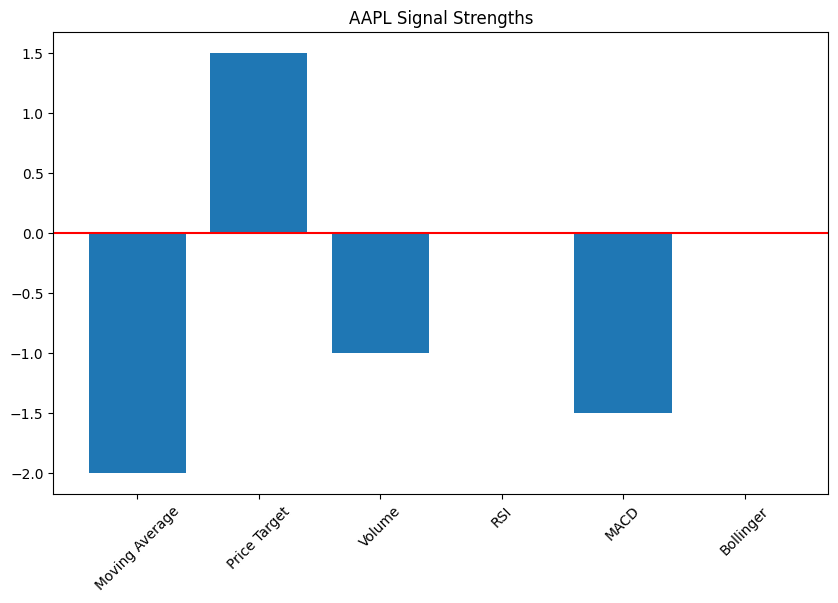

In [17]:
signal_values = {
    'Moving Average': signals[0],
    'Price Target': signals[1],
    'Volume': signals[2],
    'RSI': signals[3],
    'MACD': signals[4],
    'Bollinger': signals[5]
}

plt.figure(figsize=(10, 6))
plt.bar(signal_values.keys(), signal_values.values())
plt.title(f'{ticker} Signal Strengths')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()